<a href="https://colab.research.google.com/github/ManavSarkar/Weight-Prediction-using-Machine-Learning/blob/deep-feature-extraction/Deep_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
dataset_path = 'datasets/updated_data.csv'
import pandas as pd

df = pd.read_csv(dataset_path)


In [4]:
# dividing the dataset into train, test and validation sets by adding an extra column
from sklearn.model_selection import train_test_split

# Specify the column to use for the split (e.g., 'img_name')
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, validation = train_test_split(train, test_size=0.2, random_state=42)
#  80% of the data is used for training, 10% for testing, and 10% for validation. 

In [5]:
df['split'] = 'train'  # Set default value to 'train'
df.loc[df.index.isin(test.index), 'split'] = 'test'
df.loc[df.index.isin(validation.index), 'split'] = 'validation'
df.to_csv('datasets/updated_data.csv', index=False)

df['bmi'] = df['weight']/df['height']**2


In [6]:
df.head()

,img_name,sex,age,height,weight,split,bmi
0,000002_F_18_165100_8482178.jpg,0,18,1.6510,84.82178,test,31.118112
1,000003_F_18_170180_3991613.jpg,0,18,1.7018,39.91613,train,13.782608
2,000003_F_18_170180_7257478.jpg,0,18,1.7018,72.57478,validation,25.059286
3,000004_F_22_157480_5606402.jpg,0,22,1.5748,56.06402,train,22.606505
4,000004_F_22_157480_6245967.jpg,0,22,1.5748,62.45967,train,25.185401


In [7]:
# first getting ResNet 101 model from torch
import torch
resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)

Using cache found in /home/studio-lab-user/.cache/torch/hub/pytorch_vision_v0.10.0


In [8]:
# replacing last layer with 15 features instead of 1000
import torch
import torch.nn as nn
resnet_model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(True),
    nn.Linear(1024, 512),
    nn.ReLU(True),
    nn.Linear(512, 256),
    nn.ReLU(True),
    nn.Linear(256, 20),
    nn.ReLU(True),
    nn.Linear(20, 1)
)

In [9]:
# using the adam optimizer with learning rate of 0.0001 first and second momentum of 0.9 and 0.999 respectively
import torch.optim as optim
optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.001)

In [10]:
# scaling the longer side of image to 224 and pad the shorter size with zeroes to match 224x224
from PIL import Image, ImageOps

def scale_and_pad(img):
    width, height = img.size
    if width > height:
        scale = 224 / width
        new_height = int(height * scale)
        img = img.resize((224, new_height))
        padding = (224 - new_height) // 2
        img = ImageOps.expand(img, (0, padding, 0, 224 - new_height - padding))
    else:
        scale = 224 / height
        new_width = int(width * scale)
        img = img.resize((new_width, 224))
        padding = (224 - new_width) // 2
        img = ImageOps.expand(img, (padding, 0, 224 - new_width - padding, 0))
    return img




In [11]:
# transform an image from datasets/images/ to a tensor
from PIL import Image
img_path = 'datasets/Images/002274_M_35_175260_12337713.jpg'
img = Image.open(img_path)
img = scale_and_pad(img)


In [12]:
# normalized with mean values[0.485, 0.456, 0.406] 
# and standard deviation values[0.229, 0.224, 0.225]
from torchvision import transforms
IMG_SIZE = 224
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMG_MEAN, IMG_STD)
])

img = transform(img)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


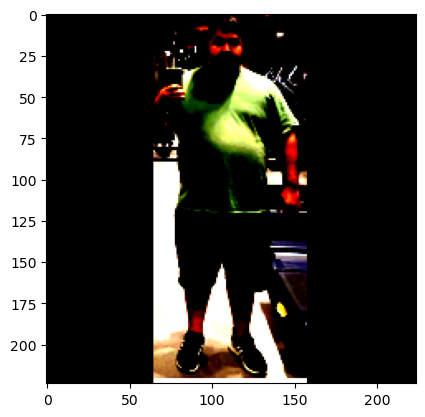

In [13]:
# plot the image
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))


In [14]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import re
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.data = dataset
        self.transform = transform

    def __len__(self):
        return len(self.data.index)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0] 
        img_path = 'datasets/Images/' + img_name  # adjust the path to your actual image directory
        image = Image.open(img_path)
        image = scale_and_pad(image)
        ret = re.match(r"\d+?_([FMfm])_(\d+?)_(\d+?)_(\d+).+", img_name)
        BMI = (int(ret.group(4)) / 100000) / (int(ret.group(3)) / 100000) ** 2
        
        if self.transform:
            image = self.transform(image)

        return (image,img_name), BMI

In [15]:
train_data = df[df['split'] == 'train']
test_data = df[df['split'] == 'test']
val_data = df[df['split'] == 'validation']

batch_size = 64
train_dataset = CustomDataset(train_data, transform=transform)
test_dataset = CustomDataset(test_data, transform=transform)
val_dataset = CustomDataset(val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [16]:
print(len(val_loader))

622


In [17]:
# train the resnet model on the train_img_tensors and train_labels
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from sklearn.metrics import mean_absolute_error
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [18]:

resnet_model = resnet_model.to(device)
criterion = nn.MSELoss()



In [19]:
def train(model, device, train_loader, epoch):
    model.train()
    running_loss = 0.0
    for idx, ((x,n),y) in enumerate(train_loader,0):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        # print(y_pred.shape)
        y = torch.unsqueeze(y,1)
        loss = criterion(y_pred.double(), y.double())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print('loss: ', loss.item())
    print('Train Epoch:{}\t RealLoss:{:.6f}'.format(epoch, running_loss / len(train_loader)))

In [20]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
def test(model, device, test_loader):
    model.eval()
    pred = []
    targ = []
    with torch.no_grad():
        for i, ((x, n), y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            # optimizer.zero_grad()
            y_pred = model(x)
            # print(y_pred.shape)
            pred.append(y_pred.item())
            targ.append(y.item())
            y = torch.unsqueeze(y, 1)
    MAE = mean_absolute_error(targ, pred)
    MAPE = mean_absolute_percentage_error(targ, pred)
    print('\nTest MAE:{}\t Test MAPE:{} '.format(MAE, MAPE))
    return MAE, MAPE

In [20]:
MIN_MAE, MAPE = test(resnet_model, device, val_loader)


Test MAE:30.32943829239959	 Test MAPE:100.333489801653 


In [21]:
MIN_MAE

30.32943829239959

In [ ]:
for epoch in range(100):
    print('*' * 50)
    train(resnet_model, device, train_loader, epoch)
    val_MAE, val_MAPE = test(resnet_model, device, val_loader)
    if val_MAE < MIN_MAE:
        MIN_MAE = val_MAE
        torch.save(resnet_model.state_dict(), 'MIN_RESNET101_BMI_Cache_test.pkl')
        END_EPOCH = epoch


In [22]:
Net = resnet_model
Net.load_state_dict(torch.load('MIN_RESNET101_BMI_Cache.pkl', map_location=torch.device('cpu')))
Net = Net.to(device)

In [23]:
print('=' * 50)
Net.eval()
test(Net, device, test_loader)


Test MAE:6.83262550017427	 Test MAPE:23.848494128167054 


(6.83262550017427, 23.848494128167054)